# CNN - normal & pneumonia (chest_xray)

In [75]:
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import cv2

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader

import random
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [76]:
train_dir = './data/chest_xray/train'
test_dir = './data/chest_xray/test'
val_dir = './data/chest_xray/val'

In [77]:
train_classes = os.listdir(train_dir)
val_classes = os.listdir(val_dir)
test_classes = os.listdir(test_dir)

train_count = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in train_classes}
val_count = {cls: len(os.listdir(os.path.join(val_dir, cls))) for cls in val_classes}
test_count = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in test_classes}

print(f'Training: {train_count}')
print(f'Validation: {val_count}')
print(f'Test: {test_count}')

Training: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation: {'NORMAL': 8, 'PNEUMONIA': 8}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


# Data Loading

1. Merge all files into the mix by category, while retaining the normal and pneumonia categories.

In [ ]:
""" # path
src_folder = "./data/chest_xray"
dst_folder = os.path.join(src_folder, "mix")

# destination path
normal_dst = os.path.join(dst_folder, "normal")
pneumonia_dst = os.path.join(dst_folder, "pneumonia")

# create mix/normal and mix/pneumonia files (if not exist)
os.makedirs(normal_dst, exist_ok=True)
os.makedirs(pneumonia_dst, exist_ok=True)

# move files in normal and pneumonia files
for category in ["train", "val", "test"]:
    for label in ["normal", "pneumonia"]:
        src_path = os.path.join(src_folder, category, label)
        
        # check if the path exists
        if os.path.exists(src_path):
            for filename in os.listdir(src_path):
                src_file = os.path.join(src_path, filename)
                
                # move files to relative folders in mix
                if label == "normal":
                    shutil.move(src_file, normal_dst)
                elif label == "pneumonia":
                    shutil.move(src_file, pneumonia_dst) """



' # 设置原始文件夹路径和目标文件夹路径\nsrc_folder = "./data/chest_xray"\ndst_folder = os.path.join(src_folder, "mix")\n\n# 定义目标分类文件夹的路径\nnormal_dst = os.path.join(dst_folder, "normal")\npneumonia_dst = os.path.join(dst_folder, "pneumonia")\n\n# 创建 mix/normal 和 mix/pneumonia 文件夹（如果不存在）\nos.makedirs(normal_dst, exist_ok=True)\nos.makedirs(pneumonia_dst, exist_ok=True)\n\n# 遍历 train、val 和 test 文件夹，将 normal 和 pneumonia 文件夹中的文件移动到目标文件夹中\nfor category in ["train", "val", "test"]:\n    for label in ["normal", "pneumonia"]:\n        src_path = os.path.join(src_folder, category, label)\n        \n        # 检查路径是否存在\n        if os.path.exists(src_path):\n            for filename in os.listdir(src_path):\n                src_file = os.path.join(src_path, filename)\n                \n                # 将文件移动到 mix 的相应分类文件夹\n                if label == "normal":\n                    shutil.move(src_file, normal_dst)\n                elif label == "pneumonia":\n                    shutil.move(src_file, pneumonia_dst)

2. Randomly split the dataset

In [79]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [80]:
# 定义路径
mix_folder = "./data/chest_xray/mix"
normal_folder = os.path.join(mix_folder, "normal")
pneumonia_folder = os.path.join(mix_folder, "pneumonia")

mix_dir = os.path.join("./data/chest_xray",'mix')
mix_dataset = datasets.ImageFolder(mix_dir, transform = data_transforms)

train_size = int(0.8 * len(mix_dataset))
temp_size = len(mix_dataset) - train_size
train_subset, temp_subset = random_split(mix_dataset, [train_size, temp_size])
val_size, test_size = temp_size // 2, temp_size // 2
val_subset, test_subset = random_split(temp_subset, [val_size, test_size])

# 打印每个集合的大小
print(f"training data size: {len(train_subset)}")
print(f"validation data size: {len(val_subset)}")
print(f"test data size: {len(test_subset)}")


training data size: 4684
validation data size: 586
test data size: 586


# Function

In [81]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    history = {'train_loss': [], 'val_loss': [],
               'train_accuracy': [], 'val_accuracy': [],
               'train_f1': [], 'val_f1': [],
               'train_precision': [], 'val_precision': [],
               'train_recall': [], 'val_recall': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')
        train_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
        
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1'].append(train_f1)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_accuracy = (torch.tensor(all_val_preds) == torch.tensor(all_val_labels)).sum().item() / len(all_val_labels)
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)

        print(f'Train: Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1-score: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}')
        print(f'Validation: Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1-score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')
        print()
    
    return history

In [82]:
def evaluate_model_on_test(model, test_loader, criterion, device='cpu'):
    model.eval()  
    
    test_loss = 0.0
    all_test_preds = []
    all_test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
    test_precision = precision_score(all_test_labels, all_test_preds, average='weighted')
    test_recall = recall_score(all_test_labels, all_test_preds, average='weighted')
    test_accuracy = (torch.tensor(all_test_preds) == torch.tensor(all_test_labels)).sum().item() / len(all_test_labels)

    print(f'Test: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1-score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')
    
    return test_loss, test_accuracy, test_f1, test_precision, test_recall

In [83]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # F1-Score
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1-Score')
    plt.plot(epochs, history['val_f1'], label='Validation F1-Score')
    plt.title('F1-Score')
    plt.legend()

    # Precision
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Validation Precision')
    plt.title('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Validation Recall')
    plt.title('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [84]:
def evaluate_and_plot_confusion_matrix(model, test_loader, device='cpu'):
    model.eval()  
    all_test_preds = []
    all_test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_test_labels, all_test_preds)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [85]:
def plot_confusion_matrix_validation(model, val_loader, device='cpu'):
    model.eval()  
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_val_labels, all_val_preds)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix - Validation Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [86]:
def show_images(dataset_dir, class_name, num_images=5):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)[:num_images]
    
    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

In [87]:
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDenseNet, self).__init__()
        
        self.densenet = models.densenet121(pretrained=True)
        
        for param in self.densenet.parameters():
            param.requires_grad = False
        
        num_ftrs = self.densenet.classifier.in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),       
            nn.ReLU(),
            nn.BatchNorm1d(512),                       
            nn.Dropout(0.3), # 可以尝试0.1，0.2              
            nn.Linear(512, 256),             
            nn.ReLU(),                       
            nn.BatchNorm1d(256),            
            nn.Linear(256, num_classes)      
        )
    
    def forward(self, x):
        x = self.densenet.features(x)
        x = nn.functional.relu(x, inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        
        x = self.classifier(x)
        return x

In [ ]:
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True) # 128可能还是太大了？
val_loader = DataLoader(val_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

In [89]:
num_classes = 2
model = CustomDenseNet(num_classes)

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
num_epochs = 10
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

c:\Users\Churou\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Churou\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
--------------------
Train: Loss: 0.2383, Accuracy: 0.9114, F1-score: 0.9132, Precision: 0.9183, Recall: 0.9114
Validation: Loss: 0.8703, Accuracy: 0.7645, F1-score: 0.6803, Precision: 0.8211, Recall: 0.7645

Epoch 2/10
--------------------
Train: Loss: 0.1222, Accuracy: 0.9607, F1-score: 0.9607, Precision: 0.9607, Recall: 0.9607
Validation: Loss: 0.2052, Accuracy: 0.9369, F1-score: 0.9377, Precision: 0.9396, Recall: 0.9369

Epoch 3/10
--------------------
Train: Loss: 0.0951, Accuracy: 0.9682, F1-score: 0.9681, Precision: 0.9681, Recall: 0.9682
Validation: Loss: 0.2409, Accuracy: 0.9386, F1-score: 0.9399, Precision: 0.9443, Recall: 0.9386

Epoch 4/10
--------------------
Train: Loss: 0.0858, Accuracy: 0.9708, F1-score: 0.9707, Precision: 0.9707, Recall: 0.9708
Validation: Loss: 0.1603, Accuracy: 0.9539, F1-score: 0.9537, Precision: 0.9536, Recall: 0.9539

Epoch 5/10
--------------------
Train: Loss: 0.0624, Accuracy: 0.9782, F1-score: 0.9782, Precision: 0.9782, Recall: 0.97

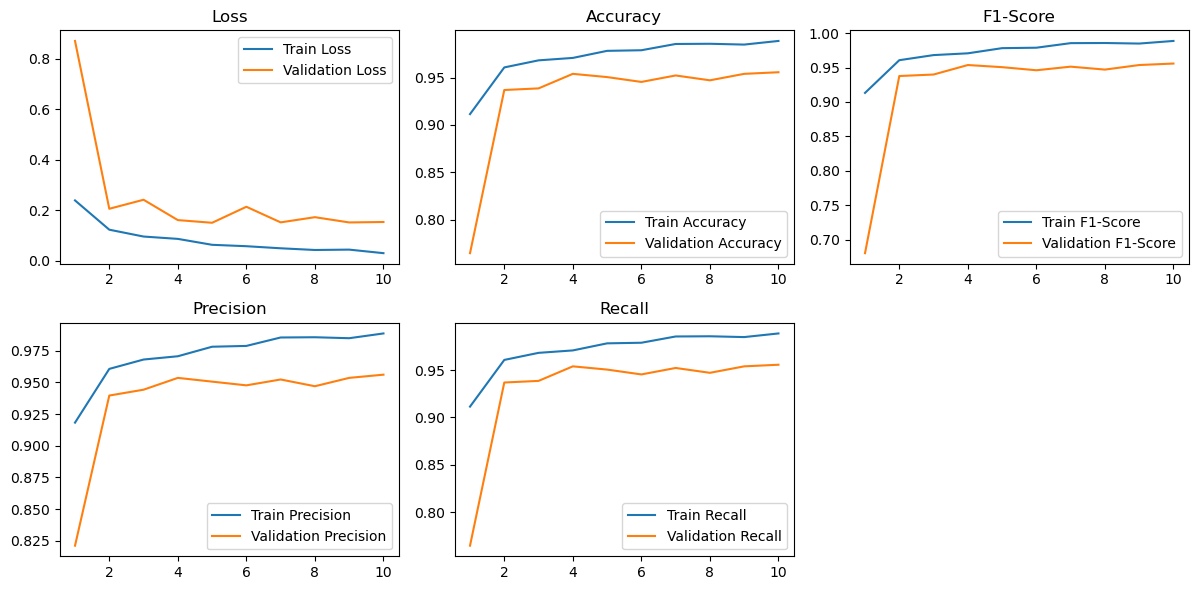

In [90]:
plot_metrics(history)

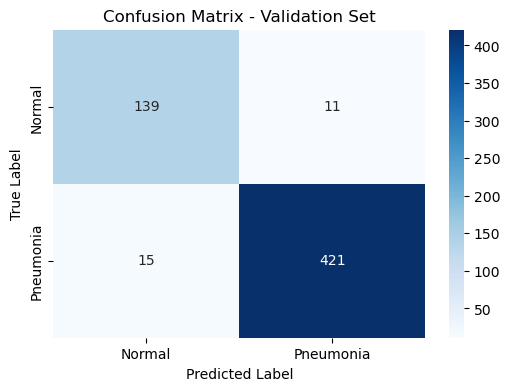

In [91]:
plot_confusion_matrix_validation(model, val_loader, device)

In [92]:
test_loss, test_accuracy, test_f1, test_precision, test_recall = evaluate_model_on_test(model, test_loader, criterion, device)

Test: Loss: 0.2256, Accuracy: 0.9334, F1-score: 0.9343, Precision: 0.9363, Recall: 0.9334


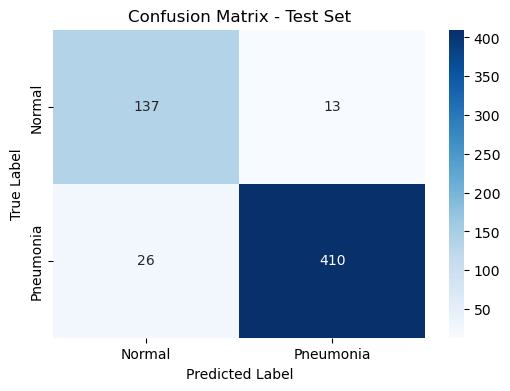

In [93]:
evaluate_and_plot_confusion_matrix(model, test_loader, device)

In [ ]:
# if gradient vanish exists?
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} gradient mean: {param.grad.abs().mean().item()}")

classifier.0.weight gradient mean: 0.00029378331964835525
classifier.0.bias gradient mean: 3.679420842672698e-05
classifier.2.weight gradient mean: 0.00042797179776243865
classifier.2.bias gradient mean: 0.0009650144493207335
classifier.4.weight gradient mean: 0.0004035937017761171
classifier.4.bias gradient mean: 0.00046650489093735814
classifier.6.weight gradient mean: 0.0005201733438298106
classifier.6.bias gradient mean: 0.0008558697300031781
classifier.7.weight gradient mean: 0.0066445861011743546
classifier.7.bias gradient mean: 0.01120607927441597
